In [1]:
import re
import os
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def load_phobius(path):
    with open(specie, 'rt') as file:
        data = dict()
        for line in file:
            if line.startswith('ID'):
                prot = re.match(r"ID\s+([^\s]+).*", line).group(1)
                mylist = data.setdefault(prot, list())
                continue
            m = re.match(r"(FT)\s+(TRANSMEM)\s+(\d+)\s+(\d+)\s*", line)
            if m is None:
                continue
            _, _, start, end = re.match(r"(FT)\s+(TRANSMEM)\s+(\d+)\s+(\d+)\s*", line).group(1, 2, 3, 4)
            mylist.append((int(start), int(end)))
    return data

In [3]:
domains = {}
domain_path = Path('./domain/tmd/')
files_in_basepath = domain_path.iterdir()
domains_data = dict()
for specie in files_in_basepath:
    if specie.name.startswith("."):
        continue
    domains_data[specie.name] = load_phobius(specie)

In [4]:
SPECIES_DICT = {"cil": "WSBS $Polydora$",
                "hop": "$Polydora\ hoplura$",
                "web": "$Polydora\ websteri$",
                "bre": "$Polydora\ brevipalpa$",
                "boc": "$Bocardiela\ hamata$"}
SPECIES_DICT1 = {"cil1": "WSBS $Polydora$",
                "hop1": "$Polydora\ hoplura$",
                "web1": "$Polydora\ websteri$",
                "brev1": "$Polydora\ brevipalpa$",
                "boc1": "$Bocardiela\ hamata$"}

INVERSE_SPECIES_DICT = {v: k for k, v in SPECIES_DICT.items()}

In [6]:
form_df = list()
for sp, subdict in domains_data.items():
    for prot, sublist in subdict.items():
        for s, e in sublist:
            form_df.append({"species": os.path.splitext(sp)[0],
                            "protein": prot,
                            "start": s,
                            "end": e})
form_df = pd.DataFrame(form_df)

In [7]:
form_df
form_df["organism"] = form_df["species"].map(SPECIES_DICT1)
form_df

,species,protein,start,end,organism
0,hop1,nad6,49,72,$Polydora\ hoplura$
1,hop1,nad6,84,102,$Polydora\ hoplura$
2,hop1,nad6,122,146,$Polydora\ hoplura$
3,hop1,nad3,6,26,$Polydora\ hoplura$
4,hop1,nad3,57,79,$Polydora\ hoplura$
...,...,...,...,...,...
425,boc1,nad1,142,160,$Bocardiela\ hamata$
426,boc1,nad1,172,191,$Bocardiela\ hamata$
427,boc1,nad1,212,237,$Bocardiela\ hamata$
428,boc1,nad1,243,265,$Bocardiela\ hamata$


In [8]:
def load_weird(path):
    with open(path, "rt") as file:
        dat = dict()
        for line in file:
            pos, score = re.match(r"Position:\s+(\d+)\s+Score:\s*([^\s]+)\s*", line).group(1, 2)
            pos = int(pos)
            score = float(score)
            dat[pos] = score
    return pd.Series(dat)

In [9]:
supdata = {}
basepath = Path('./hidpb/')
files_in_basepath = basepath.iterdir()

for entry in files_in_basepath:
    if entry.name.startswith("."):
        continue
    files_in_path = entry.iterdir()
    supdata[entry.name] = {}
    for item in files_in_path:
        if item.name.startswith("."):
            continue
        supdata[entry.name][item.name] = load_weird(item)


In [10]:
supdata2 = {}
for k, v in supdata.items():
    for k2, v2 in v.items():
        supdata2.setdefault(k2, {})[k] = v2

In [12]:
STEP = 1
COLORS = ["#819F00", "#BF9B30", "#A62F00", "#25567B", "#710067"]

color_map = mpl.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)
 

In [13]:
titles = len(supdata2)

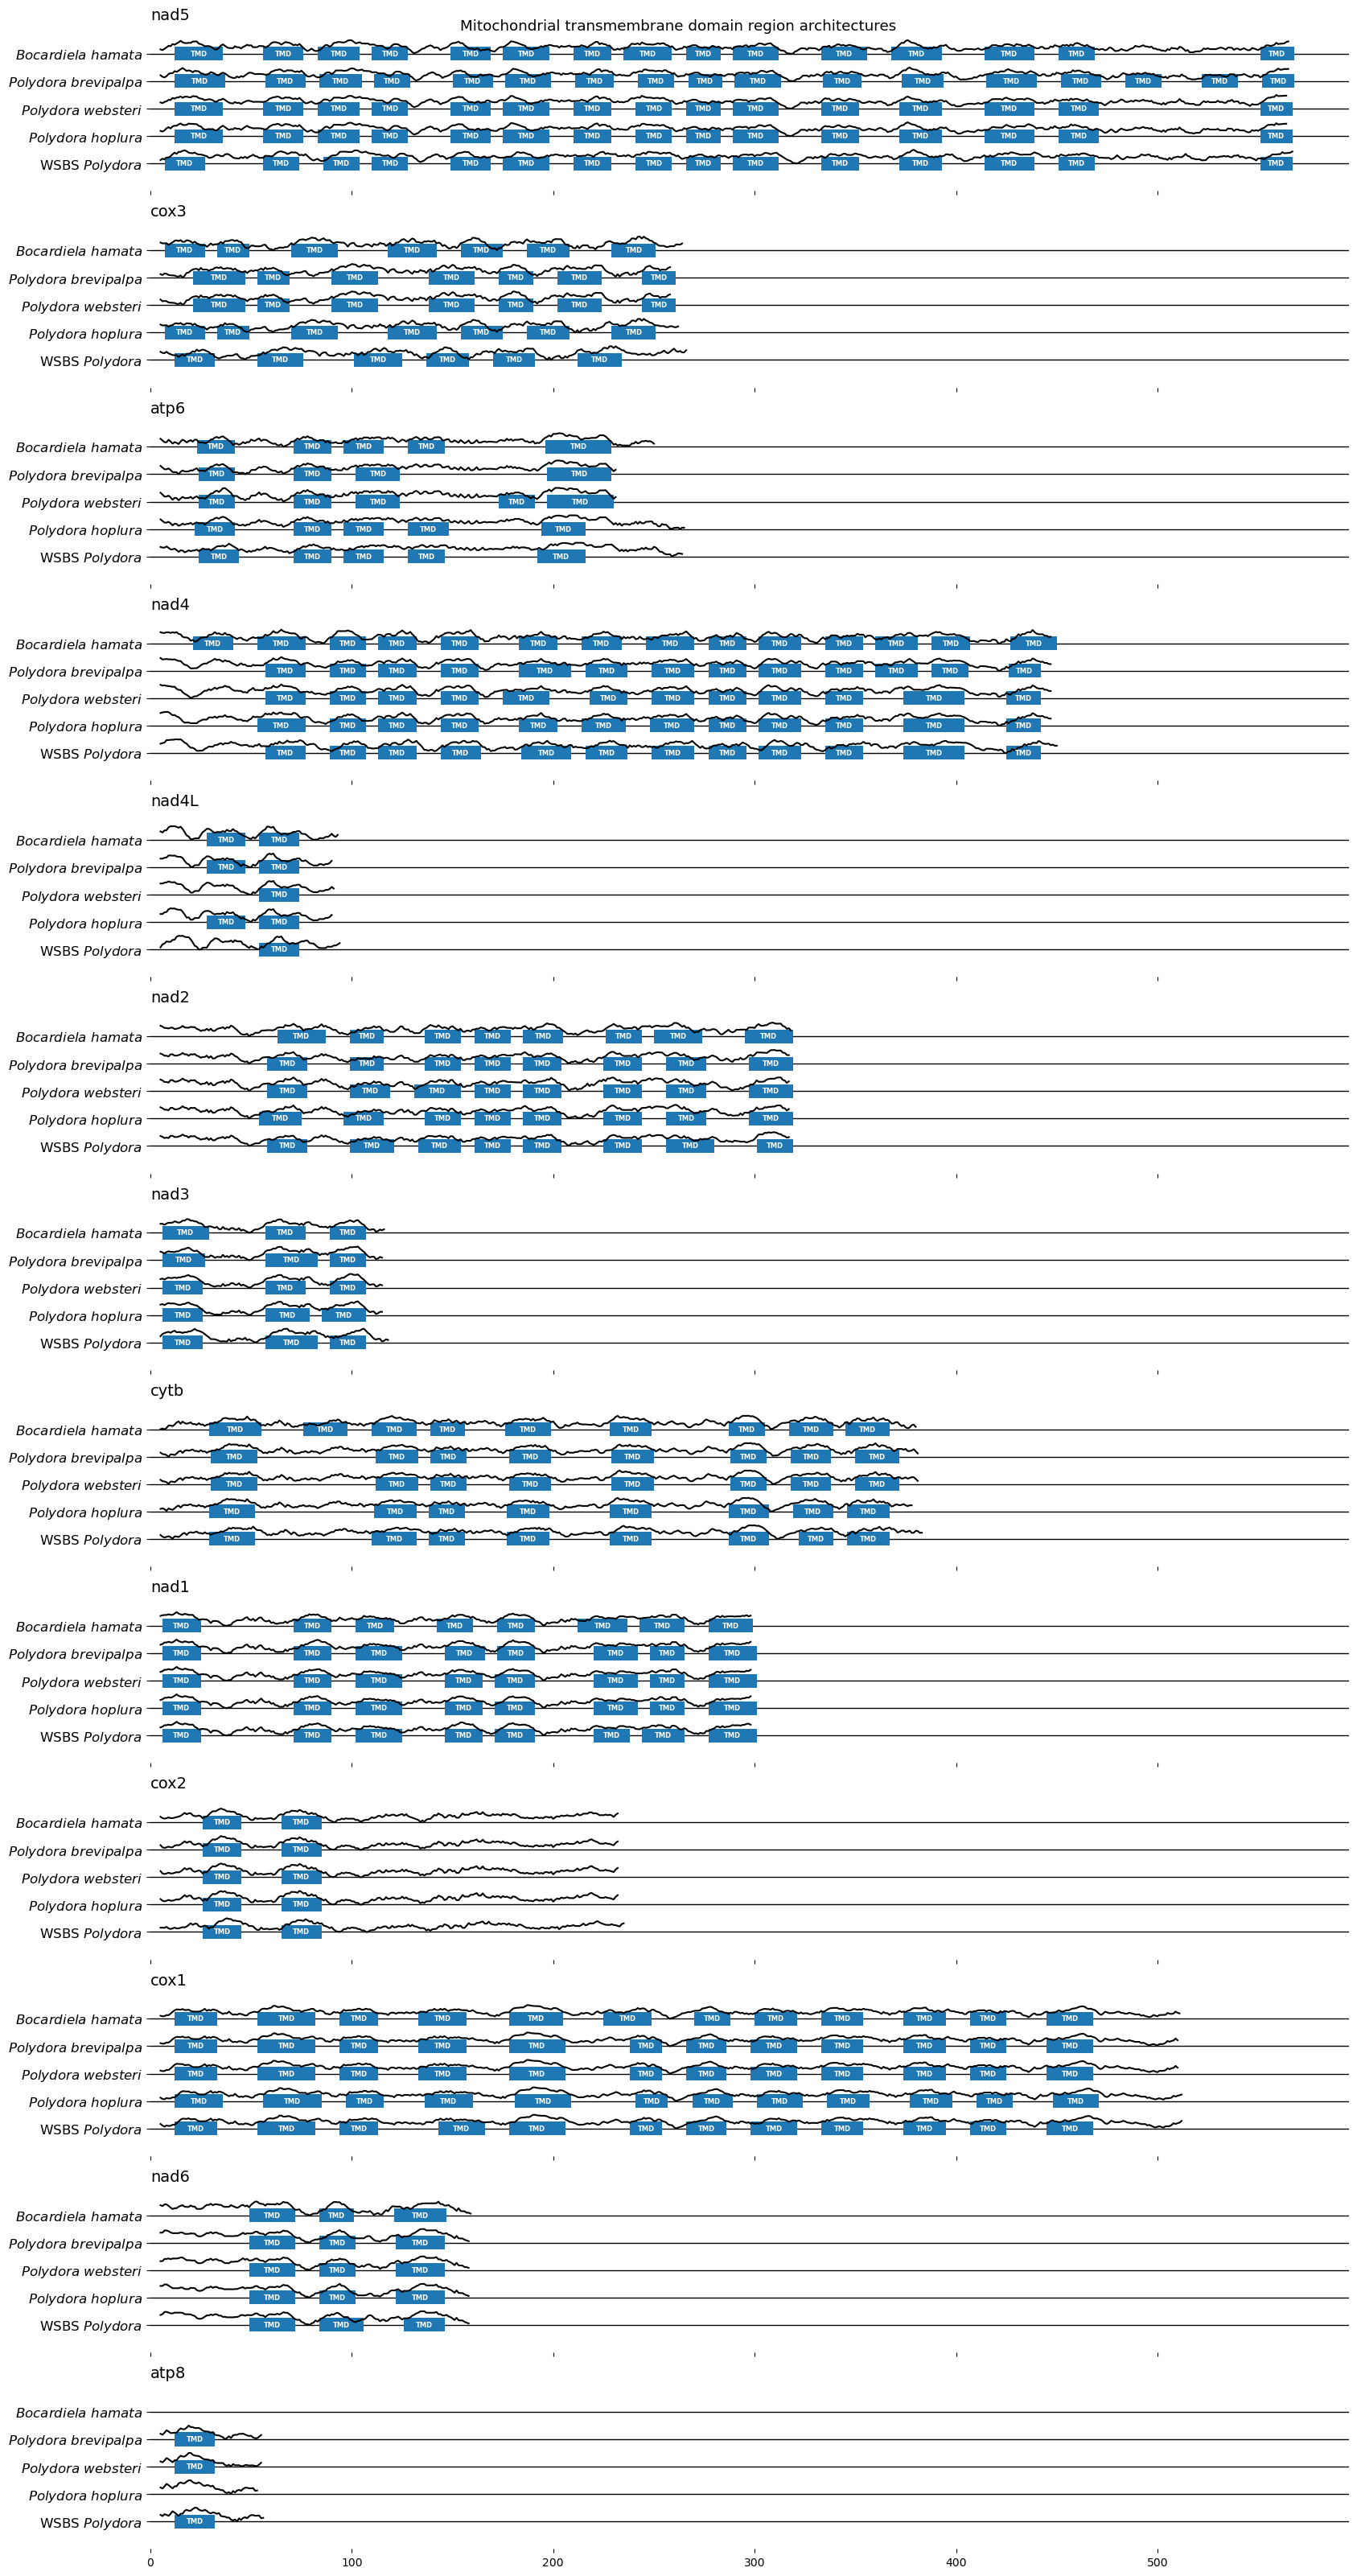

In [14]:
fig, axes = plt.subplots(titles, 1, figsize=(17, titles * 2.5), sharex=True)

axes_domains = axes.ravel()
plt.rcParams['font.size'] = '11'

uniq_sp = len(SPECIES_DICT.keys())
y_ticks_glob = np.linspace(1, uniq_sp, uniq_sp)
rect_h = 0.5
rect_text = "TMD"
for ax, prot in zip(axes_domains, supdata2.keys()):
    prot_domain_df = form_df[form_df['protein'] == prot]
    uniq_sp = prot_domain_df["species"].nunique()
    rectangles = list()
    species_names = list()
    y_ticks = np.linspace(1, uniq_sp, uniq_sp)
    for species, subdata in prot_domain_df.groupby("species"):
        y_coord = list(SPECIES_DICT1.keys()).index(species) + 1
        species_names.append(species)
        for _, row in subdata.iterrows():
            # row contains info about a rectangle
            rect_x = row["end"]
            rect_y = y_coord - rect_h / 2
            rect_w = row["start"] - row["end"]
            rect = mpl.patches.Rectangle((rect_x, rect_y), rect_w, rect_h)
            rectangles.append(rect)
    
    
    for species, y_coord in zip(list(SPECIES_DICT.keys()), y_ticks_glob):
        try:
            data = supdata2[prot][species]
        except KeyError:
            continue
        
        # -1 - 1 scaling, preserving 0:
        data = data / data.abs().max()
        # 0 - 1 scaling:
        data = (data - data.min()) / (data.max() - data.min())
        data /= 2
        data += y_coord
        ax.plot(data.index, data.values, color="k")
        
        ax.set_title(f'{prot}', fontsize=14, color='black', loc='left')
    ax.set_yticks(y_ticks_glob, SPECIES_DICT.values(), fontsize=12)
    ax.set_ylim(0, 6)
    ax.set_xlim(0)
    
    for y in y_ticks_glob:
        ax.axhline(y, color="k", lw=1, zorder=-10)
    
    for rect in rectangles:
        ax.add_artist(rect)
        rect_x, rect_y = rect.get_xy()
        text_x = rect_x + rect.get_width() / 2.0
        text_y = rect_y + rect.get_height() / 2.0
        ax.annotate(rect_text, (text_x, text_y), color='w', weight='bold',
                    fontsize=6, ha='center', va='center')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.get_xaxis().set_ticks([])

plt.suptitle(f"Mitochondrial transmembrane domain region architectures")
plt.tight_layout()
plt.savefig(f"mito_tmds.svg")